In [1]:
from sklearn.datasets import fetch_olivetti_faces
import sys
import matplotlib.pyplot as plt
import numpy as np
import importlib
import pickle
import os
from skimage.color import rgb2gray


In [30]:
def unravel_image(image):
    num_pixels = image.shape[0]*image.shape[1]
    image_vector = np.reshape(image,(num_pixels))
    return image_vector
def ravel_image_vec(image_vector,num_pixels_per_side):
    image = np.reshape(image_vector,(num_pixels_per_side,num_pixels_per_side),'F')
    image = image.T
    return image
def project_onto_eig_vecs(vec1,eig_vecs):
    #Recall that VV^T is the matrix of orthogonal projection.
    return eig_vecs@eig_vecs.T@vec1
    

In [3]:
def plot_image_grid(images, title, image_shape=(64,64),n_col=5, n_row=2, bycol=0, row_titles=None,col_titles=None):
    fig,axes = plt.subplots(nrows=n_row,ncols=n_col,figsize=(2. * n_col, 2.26 * n_row))
    for i, comp in enumerate(images):
        row,col = reversed(divmod(i,n_row)) if bycol else divmod(i,n_col)       
        cax = axes[row,col]
        cax.imshow(comp.reshape(image_shape), cmap='gray',
                   interpolation='nearest',
                   vmin=comp.min(), vmax=comp.max())
        cax.set_xticks(())
        cax.set_yticks(())
    if row_titles is not None :
        for ax,row in zip(axes[:,0],row_titles) :
            ax.set_ylabel(row,size='large')
    if col_titles is not None :
        for ax,col in zip(axes[0],col_titles) :
            ax.set_title(col)
    
    fig.suptitle(title)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(title + '.pdf',bbox_inches='tight')
    plt.show()

# Make Graphs of "Eigenfaces"


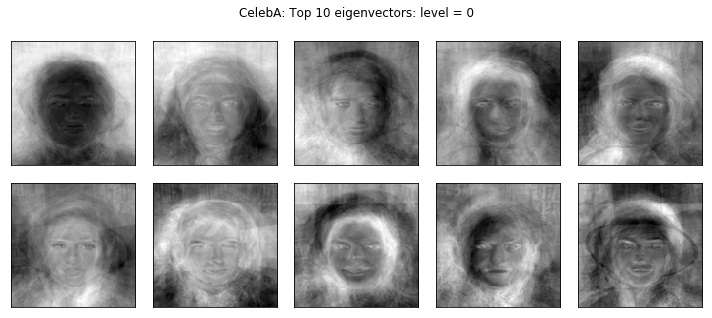

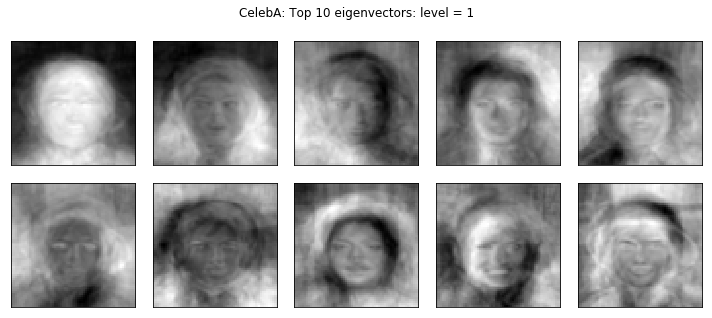

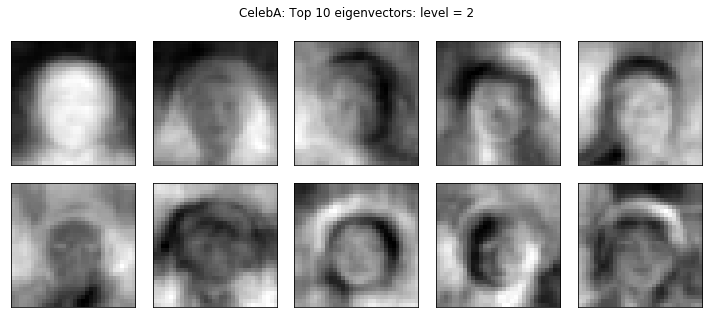

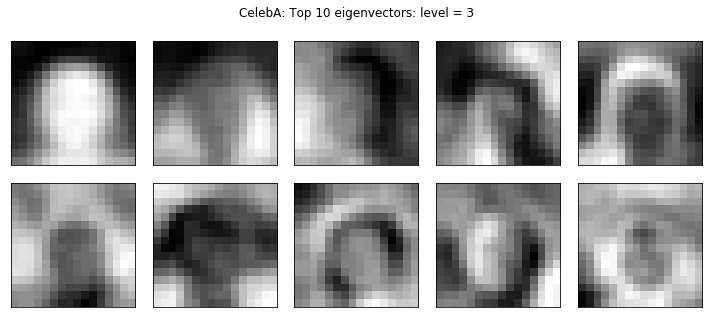

In [4]:
file='../analysis_data/celebA_orig_eigen.p'
eig_val_vecs=pickle.load(open(file,'rb'))
for level,_ in enumerate(eig_val_vecs):
    eig_vals = eig_val_vecs[level][0] 
    eig_vecs = eig_val_vecs[level][1] 
    images = eig_vecs[-10:] 
    images = np.flipud(images)
    plot_title = 'CelebA: ' + 'Top 10 eigenvectors: level = ' +str(level)
    plot_image_grid(images,plot_title ,image_shape=eig_vecs[0].shape)


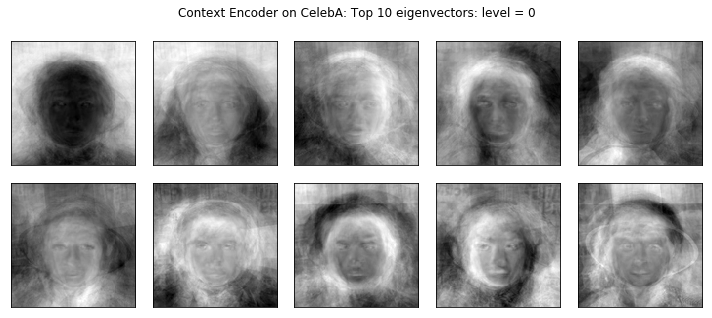

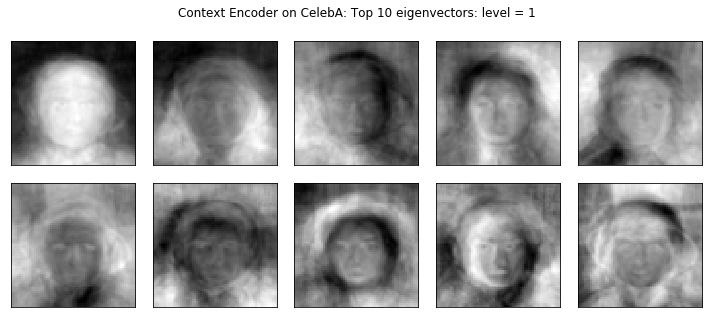

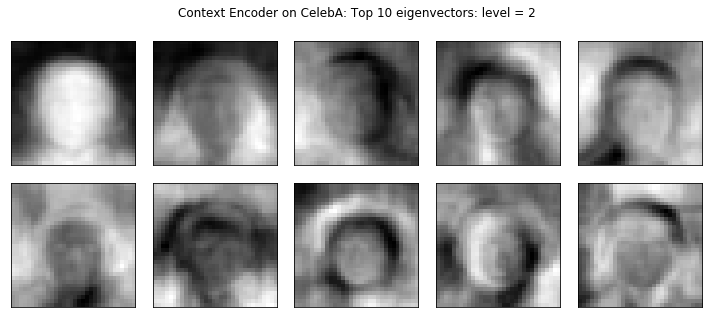

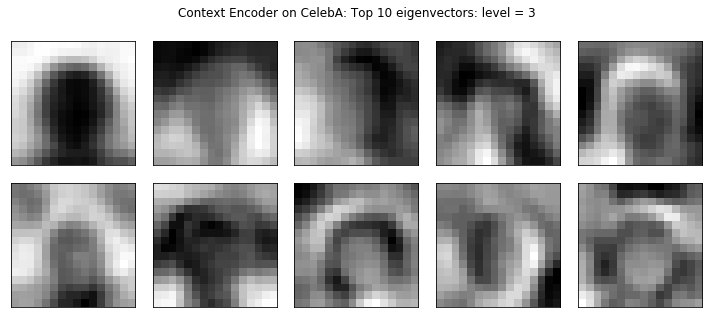

In [5]:
file='../analysis_data/celebA_recons_eigen.p'
eig_val_vecs=pickle.load(open(file,'rb'))
for level,_ in enumerate(eig_val_vecs):
    eig_vals = eig_val_vecs[level][0] 
    eig_vecs = eig_val_vecs[level][1] 
    images = eig_vecs[-10:] 
    images = np.flipud(images)
    plot_title = 'Context Encoder on CelebA: ' + 'Top 10 eigenvectors: level = ' +str(level)
    plot_image_grid(images,plot_title ,image_shape=eig_vecs[0].shape)


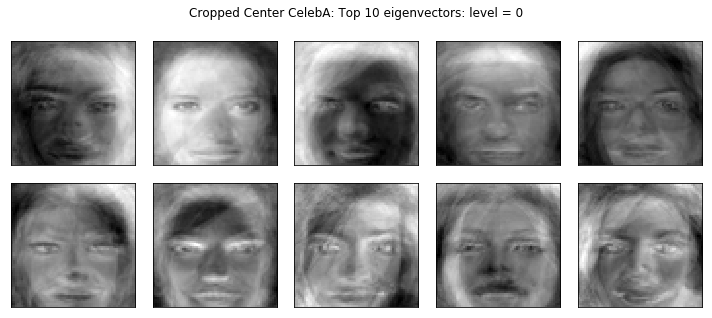

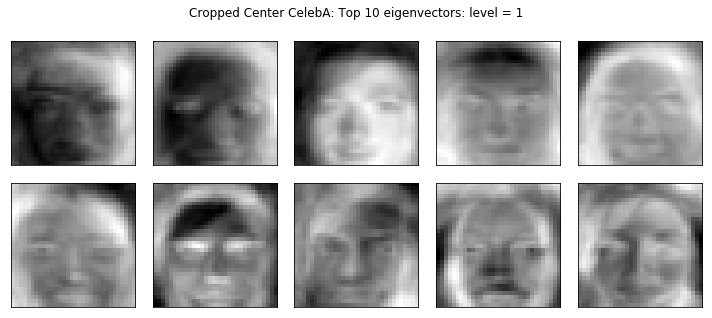

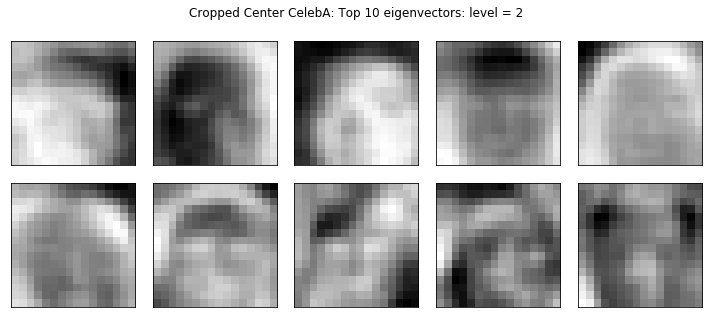

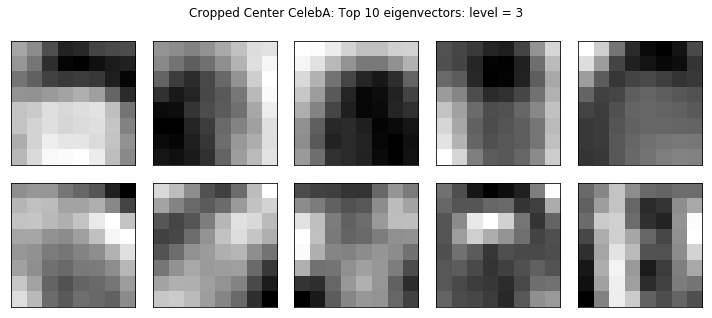

In [6]:
file='../analysis_data/celebA_orig_cropped_eigen.p'
eig_val_vecs = pickle.load(open(file,'rb'))
for level,_ in enumerate(eig_val_vecs):
    eig_vals = eig_val_vecs[level][0] 
    eig_vecs = eig_val_vecs[level][1] 
    images = eig_vecs[-10:] 
    images = np.flipud(images)
    plot_title = 'Cropped Center CelebA: ' + 'Top 10 eigenvectors: level = ' +str(level)
    plot_image_grid(images,plot_title ,image_shape=eig_vecs[0].shape)


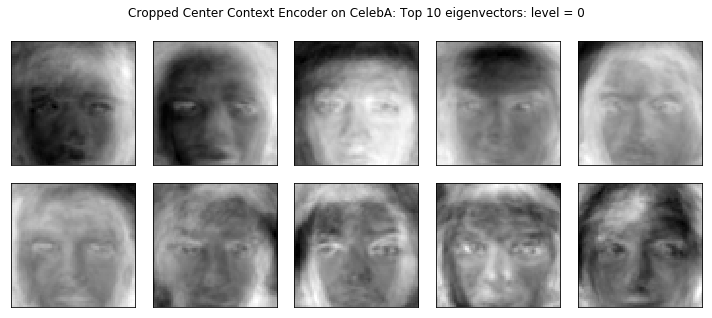

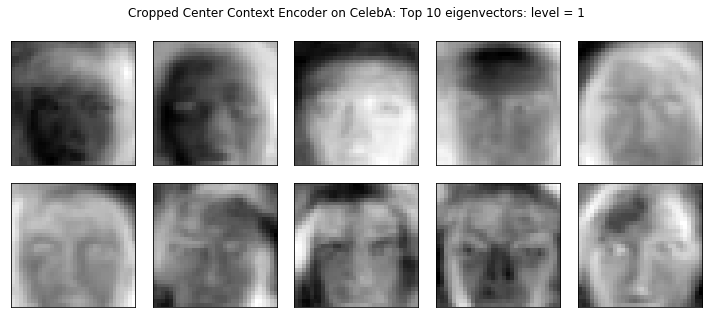

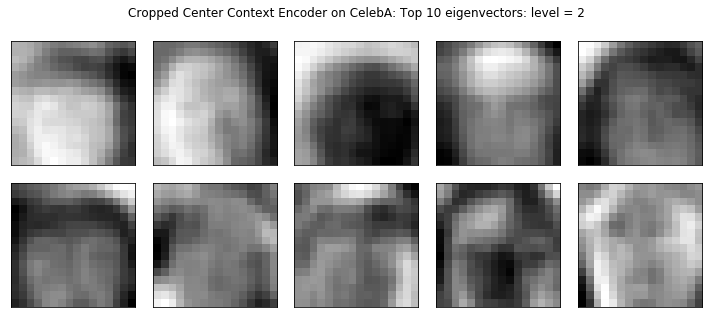

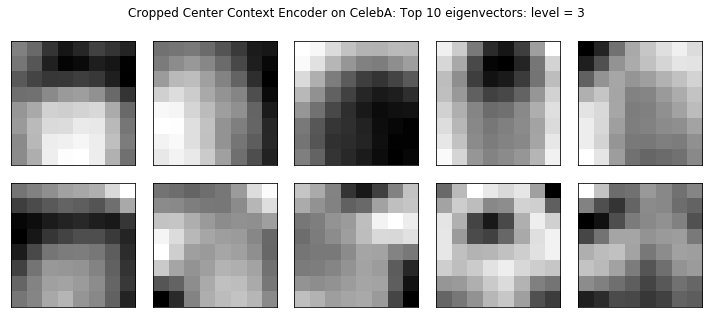

In [7]:
file='../analysis_data/celebA_recons_cropped_eigen.p'
eig_val_vecs=pickle.load(open(file,'rb'))
for level,_ in enumerate(eig_val_vecs):
    eig_vals = eig_val_vecs[level][0] 
    eig_vecs = eig_val_vecs[level][1] 
    images = eig_vecs[-10:] 
    images = np.flipud(images)
    plot_title = 'Cropped Center Context Encoder on CelebA: ' + 'Top 10 eigenvectors: level = ' +str(level)
    plot_image_grid(images,plot_title ,image_shape=eig_vecs[0].shape)


# PCA Analysis

In [8]:
file1='../analysis_data/celebA_orig_cropped_eigen.p'
file2='../analysis_data/celebA_recons_cropped_eigen.p'
orig_cropped_eig=pickle.load(open(file1,'rb'))
recons_cropped_eig=pickle.load(open(file2,'rb'))

In [9]:
input_image_dir = '../nn_output/'
original_images_path_list = []
for file in os.listdir(input_image_dir):
    if file.endswith("orig.png"):
        original_images_path_list.append(file)
print('files read')
original_images = [rgb2gray(plt.imread(input_image_dir+file)) for file in original_images_path_list]
original_cropped = [image[32:(32+64), 32:(32+64)] for image in original_images]

files read


### Level=0 (64x64)

In [17]:
orig_eig_vals = orig_cropped_eig[0][0]
orig_eig_images = orig_cropped_eig[0][1]
recons_eig_vals = recons_cropped_eig[0][0]
recons_eig_images = recons_cropped_eig[0][1]


In [18]:
sum(orig_eig_vals)

14638.01732027455

(64p x 64p) The total variance in the original images is 14638.

In [19]:
sum(recons_eig_vals)

12271.531987335558

The total variance in the reconstructed images is 12271.

Now lets compare the variance captured in the first 10 eigenvectors for the original images and reconstructed images

In [20]:
orig_eig_vals[-10:]

array([  269.44006234,   322.70747238,   347.01547286,   381.40298978,
         443.63450053,   717.15863663,  1054.85662082,  1697.88216015,
        2274.95680118,  2911.96924509])

In [21]:
recons_eig_vals[-10:]

array([  209.89957259,   232.78258088,   244.48106084,   283.30907265,
         352.04373035,   658.08107985,   958.99345968,  1560.69588828,
        1993.52560002,  2892.08086622])

We can see that the eigenvectors for the original images seem to capture more variance.

## Now, lets plot some eigenfaces for PCA-reduced images

### 10-dimension compression

In [42]:
n_dim=10
#First, we need to unravel our eigenvector images

num_pix_per_side = orig_eig_images[0].shape[0]
num_pix = orig_eig_images[0].shape[0]*orig_eig_images[0].shape[1]
image_eig_vecs = np.zeros((num_pix,n_dim))
for ii,eig_image in enumerate(orig_eig_images[-n_dim:]):
    image_eig_vecs[:,ii] = unravel_image(eig_image)
#Now,we unravel each original cropped image, and then project onto the eigenvectors
original_cropped_compressed = []   
for image in original_cropped:
    image_vec = unravel_image(image)
    vec_reduced = project_onto_eig_vecs(image_vec,image_eig_vecs)
    original_cropped_compressed.append(ravel_image_vec(vec_reduced,num_pix_per_side))


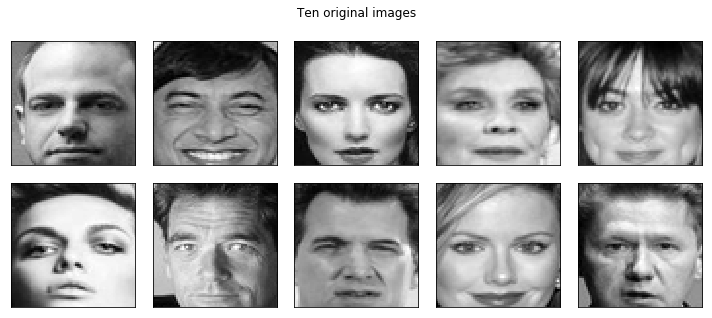

In [43]:
plot_title='Ten original images'
plot_image_grid(original_cropped[0:10],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=2
               )

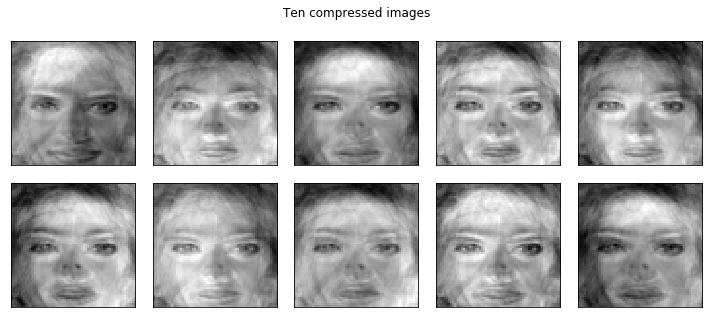

In [44]:
plot_title='Ten compressed images'
plot_image_grid(original_cropped_compressed[0:10],plot_title,
                image_shape=original_cropped_compressed[0].shape,
                n_col=5,
                n_row=2
               )